## 0. Import Libraries

In [154]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from matplotlib.lines import Line2D
import matplotlib
from shapely.geometry import mapping

import cartopy
import cartopy.io.shapereader as shpreader 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patheffects as path_effects
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from dea_tools.spatial import xr_vectorize, xr_rasterize
from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy 

import warnings
warnings.filterwarnings('ignore')

## 1. Data Options

In [12]:
general_path = 'data'
variable = 'LU_INDEX'

## 2. Open Data

In [9]:
d01_luse = xr.open_dataset(fr'{general_path}/wrfout_d01_LU_INDEX_urban.nc')[variable]
d02_luse = xr.open_dataset(fr'{general_path}/wrfout_d02_LU_INDEX_urban.nc')[variable]

d03_luse_urban = xr.open_dataset(fr'{general_path}/wrfout_d03_LU_INDEX_urban.nc')[variable]
d03_luse_nourban = xr.open_dataset(fr'{general_path}/wrfout_d03_LU_INDEX_nourban.nc')[variable]

In [17]:
# assign projection and dim info
d01_luse = d01_luse.rio.write_crs(d01_luse.attrs['pyproj_srs'])
d01_luse = d01_luse.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')

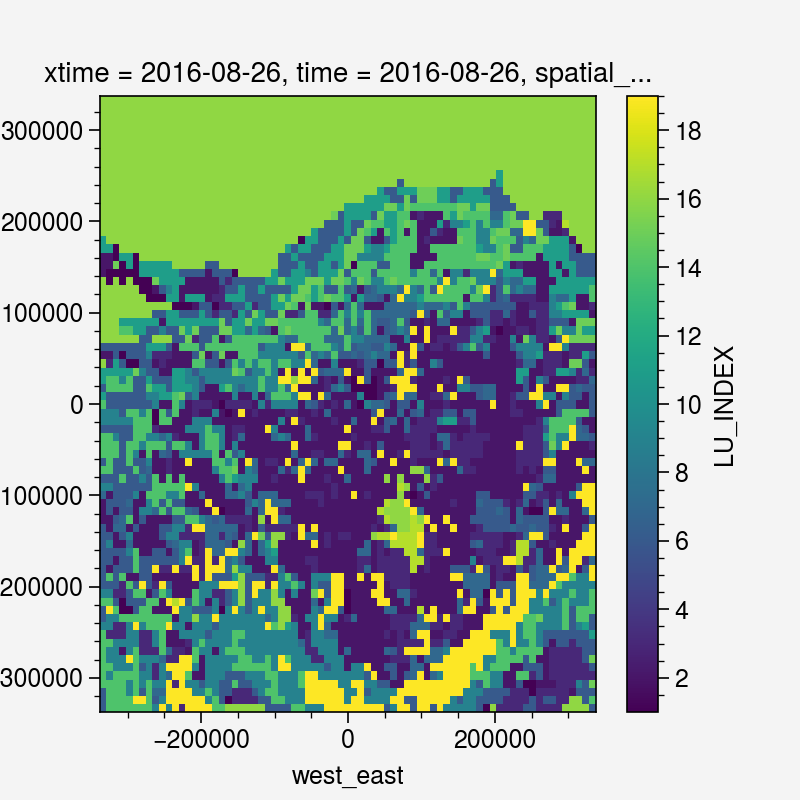

In [18]:
# example plot
d01_luse.plot()

## 3. Plot

### 3.1 Options

In [19]:
# Parameters to change (plot) -------------------
# projection
proj = d01_luse.rio.crs.to_dict()
globe = cartopy.crs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = cartopy.crs.LambertConformal(globe=globe, # important!
                            central_longitude=proj['lon_0'], 
                            central_latitude=proj['lat_0'],
                            standard_parallels=(proj['lat_1'], proj['lat_2']),
                            )

# fig features
fig_array = [[1, 1],
             [2, 3]
            ]
graphic_no = 3

### 3. Figure

In [45]:
# shapefile path names for:
shape_path = 'shapefiles'

# Ankara - province
ankara_shape = fr'{general_path}/{shape_path}/ankara_province_shape.shp'

In [142]:
# color bar creation
cb_list = ['#f00',
           '#fffcd7',
           '#797100',
           '#009d86',
           '#70cdc0',
           '#c8bb27',
           '#00b900',
           '#009200',
           '#006900',
           '#9be3ff',
           '#929292',
           '#fcee81'
          ]

labels = [
    'Urban Land',
    'Dryland, Cropland',
    'Irrigated Cropland',
    'Crops, Wood Mosaic',
    'Grassland',
    'Mix Shrubland',
    'Decidious Broadleaf Forest',
    'Evergreen Needleleaf Forest',
    'Mixed Forest',
    'Water Bodies',
    'Herbaceous Wetlands',
    'Barren or Sparsely Vegetated'
]


# make a color map of fixed colors
unique = np.unique(d03_luse_urban)
cmap = matplotlib.colors.ListedColormap(cb_list)
bounds= np.concatenate([np.array([0]), unique,])
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N,)

In [78]:
sol_alt = [38.83776093, 31.25344849]
sol_ust = [40.63642789, 31.22010389]
sag_ust = [40.63857296, 33.59054163]
sag_alt = [38.83985054, 33.56270276]

In [ ]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=10,
                            axwidth=5,
                            proj=[lcc, lcc, lcc],
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.50,
                            wspace=0.4,
                            sharey=0)

# format whole figure
axs.format(abcloc='ul',
           #abcbbox = True,
           abc=True,
           zorder=50)

# ankara limits d01
axs[0].format(lonlim=(26.2, 44.7), 
           latlim=(35.5, 42.5), 
           longrid=False, 
           latgrid = False)

# ankara limits d03
for i in range(1, 3):
    axs[i].format(lonlim=(31.25344849, 33.56270276), 
               latlim=(38.83776093, 40.63642789), 
               longrid=False, 
               latgrid = False)

# shapefile
# add shapefiles to figure
    
# Ankara - province
shape_feature_ankara = ShapelyFeature(shpreader.Reader(ankara_shape).geometries(),
                                      cartopy.crs.PlateCarree(), 
                                      facecolor='none', edgecolor = 'darkred',
                                      linewidth = 1, zorder = 30)

# add shapefiles as a feature
axs[0].add_feature(shape_feature_ankara)
axs[1].add_feature(shape_feature_ankara)
axs[2].add_feature(shape_feature_ankara)


# External complementary shapefiles
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

# external countries (shapefiles will be defined for these)
cts = ['Syria', 'Iraq', 'Iran',
       'Azerbaijan', 'Armenia',
       'Russia', 'Georgia', 'Bulgaria',
       'Greece', 'Cyprus', 'Northern Cyprus']
    
# add external shapefile geometries
for country in shpreader.Reader(shpfilename).records():
    
    if country.attributes['ADMIN'] in cts:
        
        count_shp = country.geometry
        for i in range(1):
            axs[0].add_geometries([count_shp], cartopy.crs.PlateCarree(),
                              facecolor='white', edgecolor = 'black',
                              linewidth = 0.1, zorder = 2.2,)
                
                
    elif country.attributes['ADMIN'] == 'Turkey':
        
        tr = country.geometry
        for i in range(1):
            axs[0].add_geometries([tr], cartopy.crs.PlateCarree(),
                              edgecolor='black', linewidths=0.3,
                              facecolor='white', zorder=3)
            axs[0].add_geometries([tr], cartopy.crs.PlateCarree(),
                              edgecolor='black', linewidths=0.3,
                              facecolor='none', zorder=30)
            
# facecolor
axs[0].set_facecolor("#9be3ff")

# Domain border lines on the map
left_bottom = [np.array([36.76870346, 28.77709961]),
                 np.array([38.32539749, 30.62069702]),
                 np.array([38.83776093, 31.25344849])]

left_top = [np.array([42.75070995, 28.43707218]),
             np.array([41.21169378, 30.53958811]),
             np.array([40.63642789, 31.22010389])]

right_bottom = [np.array([36.76870291, 36.2469189 ]),
             np.array([38.32706199, 34.30014276]),
             np.array([38.83985054, 33.56270276])]

right_top = [np.array([42.75070935, 36.58694782]),
             np.array([41.21342972, 34.37683012]),
             np.array([40.63857296, 33.59054163])]

# Domain name texts on the map
domain_list = ['D1', 'D2', 'D3']
for i, d_name in zip(range(3), domain_list):
    
    # domain 1
    axs[0].text(right_top[i][1], right_top[i][0]+0.05, domain_list[i],
            color='k', weight='bold', fontsize=7 ,
            transform = cartopy.crs.PlateCarree(), zorder = 15,
            horizontalalignment='right')
    
# domain borders
for i in range(3):
    lw = 1
    axs[0].plot([left_bottom[i][1], left_top[i][1],], 
            [left_bottom[i][0], left_top[i][0],],
            c='k', linewidth=lw, zorder=10,
            transform = cartopy.crs.PlateCarree(),
            )
    
    axs[0].plot([left_top[i][1], right_top[i][1],],
            [left_top[i][0], right_top[i][0],],
            c='k', linewidth=lw, zorder=10,
            transform = cartopy.crs.PlateCarree())
    
    axs[0].plot([right_top[i][1], right_bottom[i][1],],
            [right_top[i][0], right_bottom[i][0],],
            c='k', linewidth=lw, zorder=10,
            transform = cartopy.crs.PlateCarree())
    
    axs[0].plot([right_bottom[i][1], left_bottom[i][1],],
            [right_bottom[i][0], left_bottom[i][0],],
            c='k', linewidth=lw, zorder=10,
            transform = cartopy.crs.PlateCarree())
    
    
# plots

# lu_index in d01
mesh = axs[0].pcolormesh(d01_luse['lon'].values, d01_luse['lat'].values,
                      d01_luse.values-0.5, norm=norm, cmap=cmap, 
                      transform=cartopy.crs.PlateCarree(), zorder=9)

# lu_index in d02
mesh = axs[0].pcolormesh(d02_luse['lon'].values, d02_luse['lat'].values,
                      d02_luse.values-0.5, norm=norm, cmap=cmap, 
                      transform=cartopy.crs.PlateCarree(), zorder=9)

# lu_index in d03
mesh = axs[0].pcolormesh(d03_luse_urban['lon'].values, d03_luse_urban['lat'].values,
                      d03_luse_urban.values-0.5, norm=norm, cmap=cmap, 
                      transform=cartopy.crs.PlateCarree(), zorder=9)

# option b
# lu_index in d03 (urban)
mesh = axs[1].pcolormesh(d03_luse_urban['lon'].values, d03_luse_urban['lat'].values,
                      d03_luse_urban.values-0.5, norm=norm, cmap=cmap, 
                      transform=cartopy.crs.PlateCarree(), zorder=0)

# option c
# lu_index in d03 (nourban)
mesh = axs[2].pcolormesh(d03_luse_urban['lon'].values, d03_luse_urban['lat'].values,
                      d03_luse_nourban.values-0.5, norm=norm, cmap=cmap, 
                      transform=cartopy.crs.PlateCarree(), zorder=0,
                    )

custom_lines = []
for i, cb_col in enumerate(cb_list):

    custom_lines.append(Patch(facecolor=cb_col,
                               edgecolor='k',
                               label=labels[i]))

leg = fig.legend(custom_lines, 
           labels=labels,
           ncols = 3,
           loc = 'bottom',
           prop={'size': 7.25})

#save figure
plt.savefig(r'pictures/Figure2.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)